## CSCI 470 Activities and Case Studies

1. For all activities, you are allowed to collaborate with a partner. 
1. For case studies, you should work individually and are **not** allowed to collaborate.

By filling out this notebook and submitting it, you acknowledge that you are aware of the above policies and are agreeing to comply with them.

Some considerations with regard to how these notebooks will be graded:

1. Cells in which "# YOUR CODE HERE" is found are the cells where your graded code should be written.
2. In order to test out or debug your code you may also create notebook cells or edit existing notebook cells other than "# YOUR CODE HERE". We actually highly recommend you do so to gain a better understanding of what is happening. However, during grading, **these changes are ignored**. 
3. You must ensure that all your code for the particular task is available in the cells that say "# YOUR CODE HERE"
4. Every cell that says "# YOUR CODE HERE" is followed by a "raise NotImplementedError". You need to remove that line. During grading, if an error occurs then you will lose points for your work in that section.
5. If your code passes the "assert" statements, then no output will result. If your code fails the "assert" statements, you will get an "AssertionError". Getting an assertion error means you will not receive points for that particular task.
6. If you edit the "assert" statements to make your code pass, they will still fail when they are graded since the autograder will ignore the modified "assert" statement. Make sure you don't edit the assert statements.
7. We may sometimes have "hidden" tests for grading. This means that passing the visible "assert" statements is not sufficient. The "assert" statements are there as a guide but you need to make sure you understand what you're required to do and ensure that you are doing it correctly. Passing the visible tests is necessary but not sufficient to get the grade for that cell.
8. When you are asked to define a function, make sure you **don't** use any variables outside of the parameters passed to the function. You can think of the parameters being passed to the function as a hint. Make sure you're using all of those variables.
9. The **Grading** section at the end of the document (before the **Feedback** section) contains some code for our autograder on GradeScope. You are expected to fail this block of code in your Jupyter environment. DO NOT edit this block of code, or you may not get points for your assignment.
10. Finally, **make sure you run "Kernel > Restart and Run All"** and pass all the asserts before submitting. If you don't restart the kernel, there may be some code that you ran and deleted that is still being used and that was why your asserts were passing.

# Deep Learning - Recurrent Neural Networks

## NLP for sentiment analysis

### Important...
Depending on the size of your models and the number of epochs you use for training, this notebook could have lengthy runtimes. __You are encouraged to initially use at least 3 epochs of training for each model, so you can observe how well the model is or is not converging, and whether or not overfitting is occurring.__ You may even want to train for 10+ epochs and let the notebook run while you are doing something else, or overnight, to observe how many training epochs it takes for models to converge to their asypmtotes (loosely speaking).

__Prior to submittal, set the number of training epochs equal to 1, for all three models__. Otherwise the grading cannot be completed in a reasonable amount of time. __There is a test cell at the end of the notebook that checks for this.__ Thanks!

In this notebook you do not need to find hyperparameters that result in best model performance. The intent is for you to run and re-run the notebook a few times with different hyperparameters, and observe how that impacts performance (test set scores), generally.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Embedding, Dense
from tensorflow.keras import Sequential
from tensorflow.keras.datasets import imdb
import matplotlib.pyplot as plt

np.random.seed(0)
tf.random.set_seed(0)

We will be using the IMDB dataset outlined in the keras documentation [here](https://keras.io/datasets/#imdb-movie-reviews-sentiment-classification). We will be applying a supervised learning model to IMDB movie reviews (text) and predict sentiment based on that text.

Take a look at the `import`s above. For the RNN-based imports see the [RNN documentation](https://keras.io/layers/recurrent). For preprocessing using `sequence` see the [sequence documentation](https://keras.io/preprocessing/sequence). For Embedding, see the [Embedding documentation](https://keras.io/layers/embeddings/).

From the Keras documentation, linked above:
>"This is a dataset of 25,000 movies reviews from IMDB, labeled by sentiment (positive/negative). Reviews have been preprocessed, and each review is encoded as a list of word indexes (integers). For convenience, words are indexed by overall frequency in the dataset, so that for instance the integer "3" encodes the 3rd most frequent word in the data. This allows for quick filtering operations such as: "only consider the top 10,000 most common words, but eliminate the top 20 most common words."

In [2]:
# Download the IMDB data, to our specifications

n = 20000 # Only use the most frequent n words

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=n)

If you get a __VisibleDeprecationWarning__ in the cell above, you can ignore it.

In [3]:
# How many samples do we have?

print(f'The training set has {len(x_train)} samples.')
print(f'The test set has {len(x_test)} samples.')

The training set has 25000 samples.
The test set has 25000 samples.


## Text Representation

The IMDB data has already been converted from text to a sequence of numbers (indices), with each number representing an individual word (most likely, the words were lemmatized before conversion to index numbers).

In [4]:
# What do some of the individual samples looks like?

for i in range(3):
    print(f'Training sample {i} has {len(x_train[i])} items: ')
    print(x_train[i])
    print('')

Training sample 0 has 218 items: 
[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]

Training samp

In [5]:
# What are the lowest and highest indices in our training and test features?

# The data are numpy arrays, with each item in the array being a list. So
# we need to call min (max) twice to get the global min (max).

print('Training set range of indices:')
print(np.min(np.min(x_train)))
print(np.max(np.max(x_train)))

print('\nTest set range of indices:')
print(np.min(np.min(x_test)))
print(np.max(np.max(x_test)))

Training set range of indices:
1
19972

Test set range of indices:
1
19962


As expected, no index is greater than 20,000, our specified maximum number of the most frequenct words we'll allow in our vocabulary.

In [6]:
# Reviews are not of a fixed length. Let's see how long a few more of them are.

for i in range(10):
    print(f"Training sample {i} has a length of {len(x_train[i])}")

Training sample 0 has a length of 218
Training sample 1 has a length of 189
Training sample 2 has a length of 141
Training sample 3 has a length of 550
Training sample 4 has a length of 147
Training sample 5 has a length of 43
Training sample 6 has a length of 123
Training sample 7 has a length of 562
Training sample 8 has a length of 233
Training sample 9 has a length of 130


In [7]:
# Rather than process variable-length sequences (reviews), we'll
# pad sequences that are shorter than our chosen length, and trim
# off the end of sequences that are longer than that length.
# The padding value is 0, which is not in the vocabulary of indices
# given to us in the IMDB dataset (e.g., 0 does not represent/index
# a word).

maxlen = 100  # Pad or trim sequences to this length

x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

In [8]:
# Let's confirm that our samples are now of the fixed, desired length.

print(x_train.shape)
print(x_test.shape)

(25000, 100)
(25000, 100)


In [9]:
# What do our targets look like?

np.unique(y_train)

array([0, 1], dtype=int64)

## Text Representation

Again, each data sample is a sequence of integers that represent the index of the word in our vocabulary. This saves on storage when compared to a vector that's as long as our vocabulary with all 0's and just one 1 ("one-hot" coding).

We will be using the [Embedding layer](https://keras.io/layers/embeddings/) as the front-end of our neural network. The Embedding layer serves the same purpose of the Word2Vec and GloVe word representations we discussed in class. It converts the high-dimensional index-based representations (the length of that dimension being equal to the vocabulary size) to a lower-dimensional representation that is better suited for the RNN network that follows. In Word2Vec and GloVe this was done via a self-supervised learning approach (remember the skip-grams?). In our model, the embedding will be learned jointly along with the task (sentiment prediction) via supervised learning.

## Our models

We will build three networks, each using one of three different basic Recurrent Neural Network modules
1. Basic/vanilla "Simple" RNN modules
2. GRU (Gated Recurrent Unit) modules
3. LSTM (Long Short-Term Memory) modules

We will then compare their performance in predicting the binary sentiment classes of reviews.

Note that all each of the RNN modules uses a hyperbolic tangent activation, by default. This activation function constrains the output to be between -1 and 1. Due the the feedback nature of RNNs, if the activations are not contrained to this range, the outputs may eventually "blow-up" (increase until there is a numeric overflow). We'll stick with the use of that activation function. This can make learning hard, however, due to the shallow gradients imposed by the hyperbolic tangent. The LSTM and GRU modules were designed to help overcome this shallow gradient problem.

In [10]:
## Create your Simple RNN
#
# Define "layers_simple", a list of Keras layers, that you will then use to create a Sequential model
# saved as "rnn_simple".
# 
# Here you will create a simple RNN using one SimpleRNN layer with dropout and
# recurrent_dropout (see argument options in SimpleRNN documentation).
# Set the dropout rates to 0.2 to start with. After your first run, you may want to
# adjust the rates (see instructional guidance in subsequent cells).
# 
# You will need to use an Embedding layer as the first layer (to convert from 20,000 word categories
# to a lower dimensionality) followed by the SimpleRNN layer. Select an embedding size (number of
# neurons) of your choice, and use that for your SimpleRNN layer's output size as well.
# A suggesting starting range is 64 to 128 (the lower it is, the faster this notebook
# will run).
#
# Finally, create an output Dense layer with a single neuron, and an appropriate
# activation function for a binary classification task.

# YOUR CODE HERE
embedding_size = 64  
rnn_units = 64 
dropout_rate = 0.2  
recurrent_dropout_rate = 0.2  

layers_simple = [
    Embedding(input_dim=20000, output_dim=embedding_size),
    SimpleRNN(units=rnn_units, dropout=dropout_rate, recurrent_dropout=recurrent_dropout_rate),
    Dense(units=1, activation='sigmoid')  
]

rnn_simple = Sequential(layers_simple)

In [11]:
assert len(layers_simple) == 3
assert isinstance(layers_simple[0], Embedding)
assert isinstance(layers_simple[1], SimpleRNN)
assert isinstance(layers_simple[2], Dense)
assert layers_simple[0].output_dim == layers_simple[1].units
assert layers_simple[1].dropout > 0
assert layers_simple[1].recurrent_dropout > 0
assert rnn_simple

In [12]:
# Train the Simple RNN model.
# Compute metrics for the test set as well, after each training epoch.

# This may take a while. Adjust the n_epochs as you see fit, observing the
# convergence of the loss score in the plot created in the cell further below.

# IMPORTANT!!
# Set n_epochs to 3 or larger on your initial run!
# Set n_epochs to 1 for your final notebook run, before submission!
n_epochs = 1

rnn_simple.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history_simple = rnn_simple.fit(x_train, y_train,
                                validation_data=(x_test, y_test),
                                batch_size=32, epochs=n_epochs)

782/782 [==============================] - 48s 58ms/step - loss: 0.6782 - accuracy: 0.5556 - val_loss: 0.6581 - val_accuracy: 0.5843


## Is your Simple RNN model overfitting?

Examine the plot below. Near the end of training (later epochs), is the training set loss getting lower but the test set loss getting higher? If so, you model is overfitting to the training data. __You may not be able to completely prevent it, but you can try to reduce the problem by__:
1. Reducing the number of neurons in your SimpleRNN layer. This reduces the overall number of model parameters, which helps to combat overfitting.
2. Increase your dropout rates (particularly the recurrent dropout), which increases regularization.

Too much dropout (especially `dropout`, rather than `recurrent_dropout`) may actually hinder performance, on both training and test sets. Choosing dropout rates can be a bit of a guessing game, but we use scores from the test set to guide us (if we had a lot of compute time available).

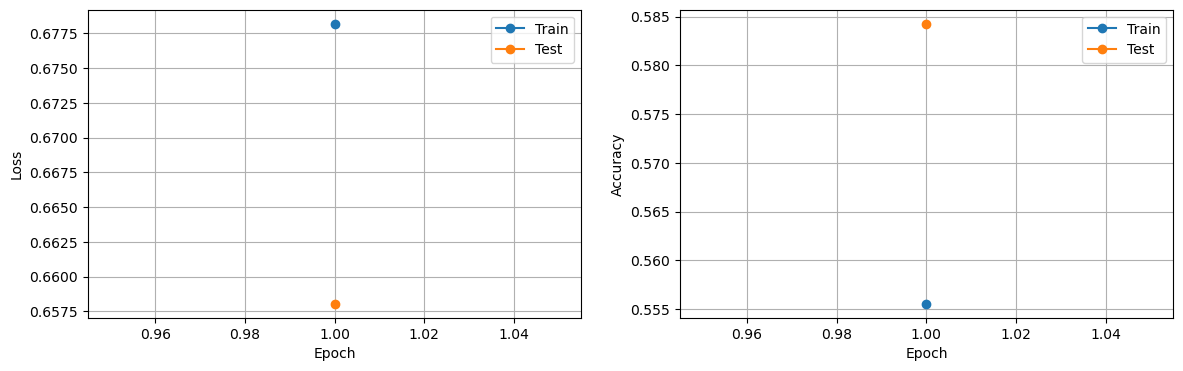

In [13]:
# Plot the loss and accuracy as a function of training epoch

plt.figure(figsize=(14, 4))

plt.subplot(1,2,1)
plt.plot(np.arange(1, n_epochs+1), history_simple.history['loss'], '-o', label='Train')
plt.plot(np.arange(1, n_epochs+1), history_simple.history['val_loss'], '-o', label='Test')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(np.arange(1, n_epochs+1), history_simple.history['accuracy'], '-o', label='Train')
plt.plot(np.arange(1, n_epochs+1), history_simple.history['val_accuracy'], '-o', label='Test')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

In [14]:
## Create your GRU RNN
#
# Define "layers_gru", a list of Keras layers, that you will then use to create a
# Sequential model saved as "rnn_gru".
#
# Here you will create an RNN using a GRU layer, with dropout and recurrent_dropout.
#
# Use an input Embedding layer and output Dense layer, as in the simple RNN model.

# YOUR CODE HERE
embedding_size = 64  
gru_units = 64  
dropout= 0.2  
recurrent_dropout = 0.2
layers_gru = [
    Embedding(input_dim=20000, output_dim=embedding_size),
    GRU(units=gru_units, dropout=dropout, recurrent_dropout=recurrent_dropout),
    Dense(units=1, activation='sigmoid') 
]

rnn_gru = Sequential(layers_gru)

In [15]:
assert len(layers_gru) == 3
assert isinstance(layers_gru[0], Embedding)
assert isinstance(layers_gru[1], GRU)
assert isinstance(layers_gru[2], Dense)
assert layers_gru[0].output_dim == layers_gru[1].units
assert layers_gru[1].dropout > 0
assert layers_gru[1].recurrent_dropout > 0
assert rnn_gru

In [16]:
# Train the GRU RNN model.
# Compute metrics for the test set as well, after each training epoch.

# This may take a while. Adjust the n_epochs as you see fit, observing the
# convergence of the loss score in the plot created in the cell further below.

# IMPORTANT!!
# Set n_epochs to 3 or larger on your initial run!
# Set n_epochs to 1 for your final notebook run, before submission!
n_epochs = 1

rnn_gru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history_gru = rnn_gru.fit(x_train, y_train,
                          validation_data=(x_test, y_test),
                          batch_size=32, epochs=n_epochs)

782/782 [==============================] - 86s 103ms/step - loss: 0.4341 - accuracy: 0.7909 - val_loss: 0.3460 - val_accuracy: 0.8505


## Is your GRU RNN model overfitting?

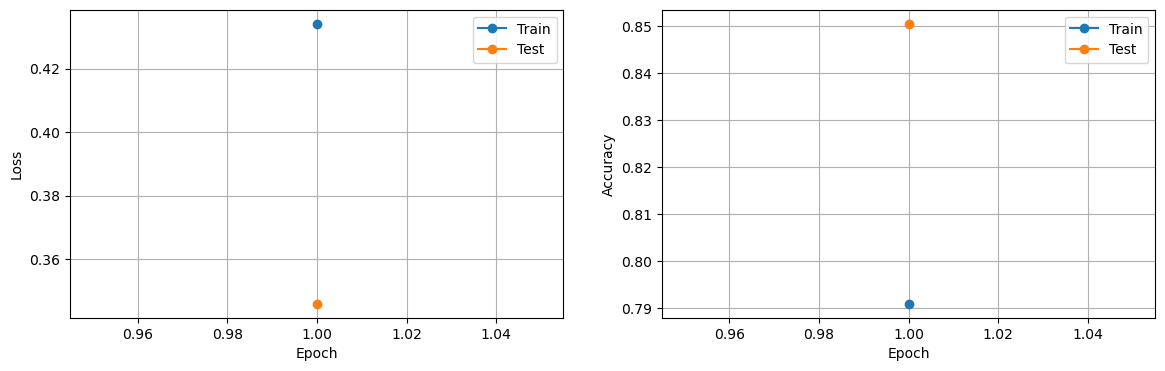

In [17]:
# Plot the loss and accuracy as a function of training epoch

plt.figure(figsize=(14, 4))

plt.subplot(1,2,1)
plt.plot(np.arange(1, n_epochs+1), history_gru.history['loss'], '-o', label='Train')
plt.plot(np.arange(1, n_epochs+1), history_gru.history['val_loss'], '-o', label='Test')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(np.arange(1, n_epochs+1), history_gru.history['accuracy'], '-o', label='Train')
plt.plot(np.arange(1, n_epochs+1), history_gru.history['val_accuracy'], '-o', label='Test')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

In [18]:
## Create your LSTM RNN
#
# Define "layers_lstm", a list of Keras layers, that you will then use to create a Sequential model
# saved as "rnn_lstm".
#
# Here you will create an RNN using an LSTM layer, again, with dropout and recurrent_dropout.
#
# Use an input Embedding layer and output Dense layer, as in the simple RNN and the GRU model.

# YOUR CODE HERE
embedding_size = 64  
lstm_units = 64  
dropout_rate = 0.2  
recurrent_dropout_rate = 0.2  
layers_lstm = [
    Embedding(input_dim=20000, output_dim=embedding_size),
    LSTM(units=lstm_units, dropout=dropout_rate, recurrent_dropout=recurrent_dropout_rate),
    Dense(units=1, activation='sigmoid')  
]

rnn_lstm = Sequential(layers_lstm)

In [19]:
assert len(layers_lstm) == 3
assert isinstance(layers_lstm[0], Embedding)
assert isinstance(layers_lstm[1], LSTM)
assert isinstance(layers_lstm[2], Dense)
assert layers_lstm[0].output_dim == layers_lstm[1].units
assert layers_lstm[1].dropout > 0
assert layers_lstm[1].recurrent_dropout > 0
assert rnn_lstm

In [20]:
# Train the LSTM RNN model.
# Compute metrics for the test set as well, after each training epoch.

# This may take a while. Adjust the n_epochs as you see fit, observing the
# convergence of the loss score in the plot created in the cell further below.

# IMPORTANT!!
# Set n_epochs to 3 or larger on your initial run!
# Set n_epochs to 1 for your final notebook run, before submission!
n_epochs = 1

rnn_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history_lstm = rnn_lstm.fit(x_train, y_train,
                            validation_data=(x_test, y_test),
                            batch_size=32, epochs=n_epochs)

782/782 [==============================] - 94s 111ms/step - loss: 0.4181 - accuracy: 0.8044 - val_loss: 0.3359 - val_accuracy: 0.8529


## Is your LSTM RNN model overfitting?

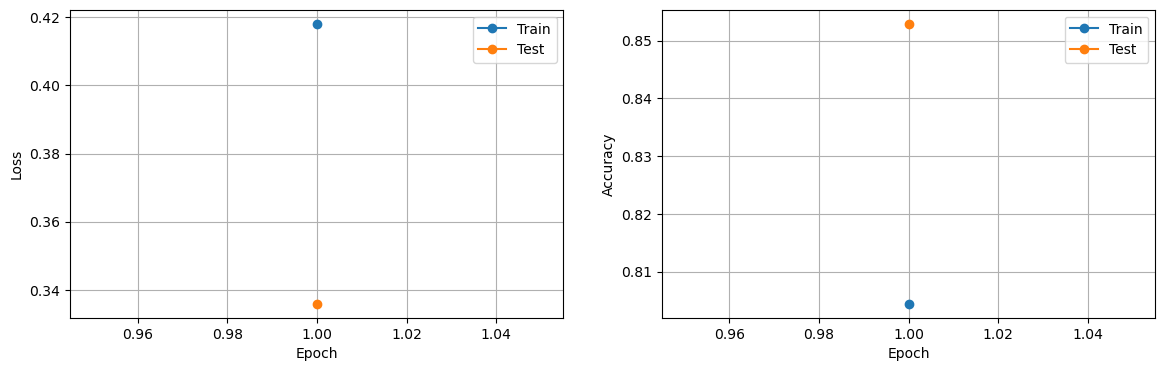

In [21]:
# Plot the loss and accuracy as a function of training epoch

plt.figure(figsize=(14, 4))

plt.subplot(1,2,1)
plt.plot(np.arange(1, n_epochs+1), history_lstm.history['loss'], '-o', label='Train')
plt.plot(np.arange(1, n_epochs+1), history_lstm.history['val_loss'], '-o', label='Test')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(np.arange(1, n_epochs+1), history_lstm.history['accuracy'], '-o', label='Train')
plt.plot(np.arange(1, n_epochs+1), history_lstm.history['val_accuracy'], '-o', label='Test')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

In [ ]:
# Apply the Model.evaluate() methods of your models to the test set and save the
# returned losses and accuracies to the corresponding variable names:
#   loss_simple, loss_gru, loss_lstm
#   acc_simple, acc_gru, acc_lstm
#
# Note that these values should be very close to the losses/accuracies in the
# plots created above, for the final epoch.

# YOUR CODE HERE
max_sequence_length = 100
x_train = sequence.pad_sequences(x_train, maxlen=max_sequence_length)
x_test = sequence.pad_sequences(x_test, maxlen=max_sequence_length)

results_simple = rnn_simple.evaluate(x_test, y_test)
loss_simple = results_simple[0]
acc_simple = results_simple[1]

results_gru = rnn_gru.evaluate(x_test, y_test)
loss_gru = results_gru[0]
acc_gru = results_gru[1]

results_lstm = rnn_lstm.evaluate(x_test, y_test)
loss_lstm = results_lstm[0]
acc_lstm = results_lstm[1]

722/782 [==========================>...] - ETA: 1s - loss: 0.3378 - accuracy: 0.8522

In [ ]:
print(f"Your simple model achieved an accuracy of {acc_simple:.2}.")
print(f"Your GRU model achieved an accuracy of {acc_gru:.2}.")
print(f"Your LSTM model achieved an accuracy of {acc_lstm:.2}.")

### Model architecture choices

Note that we created models with only __one RNN layer__. We could likely achieve better results by adding more RNN layers but the model would take a much longer time to train.

In [ ]:
assert acc_simple > 0.4
assert acc_gru > 0.6
assert acc_lstm > 0.7

In [ ]:
# These test are used to confirm that your final,
# submitted notebook used 1 and only 1 training
# epoch for each model.

assert len(history_simple.history['loss'])==1  # confirm that only one epoch of training was done
assert len(history_gru.history['loss'])==1  # confirm that only one epoch of training was done
assert len(history_lstm.history['loss'])==1  # confirm that only one epoch of training was done

# Grading
The following code block is purely used for grading. If you find any error, you can ignore. DO NOT MODIFY THE CODE BLOCK BELOW.

In [ ]:
# Autograding with Otter Grader
import otter
grader = otter.Notebook()
grader.check_all()

## Feedback

In [ ]:
def feedback():
    """Provide feedback on the contents of this exercise
    
    Returns:
        string
    """
    # YOUR CODE HERE
    return "no feedback"